In [57]:
pip install imageio

In [58]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display


In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display


In [61]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

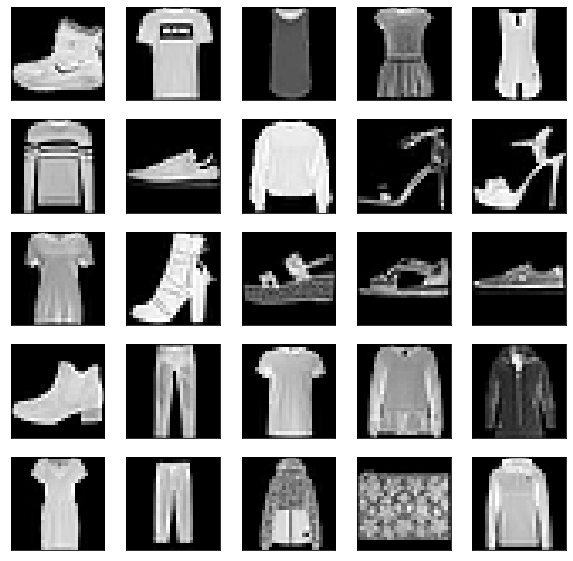

In [62]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.gray)
plt.show()

In [63]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [64]:
num_features = 100 #number of dimensions of the input latent variable space(noise)
#defining the generator
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(num_features,)))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', activation='selu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', activation='tanh'))

In [65]:
noise = tf.random.normal(shape=(1,num_features))
generated_image = generator(noise, training=False)


In [66]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=(28,28,1,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [67]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49873713]], shape=(1, 1), dtype=float32)


In [68]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
#combining the generator and the discriminator
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [69]:
seed = tf.random.normal(shape=(batch_size, num_features))

In [71]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=(batch_size, num_features))
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0) #input for discriminator
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #output for discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [77]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') #rescaling the pixel values back to 0-255 range
        plt.axis('off')
    plt.savefig('image_at_epoch_{:02d}.png'.format(epoch))
    plt.show()

In [78]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2 - 1

In [79]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

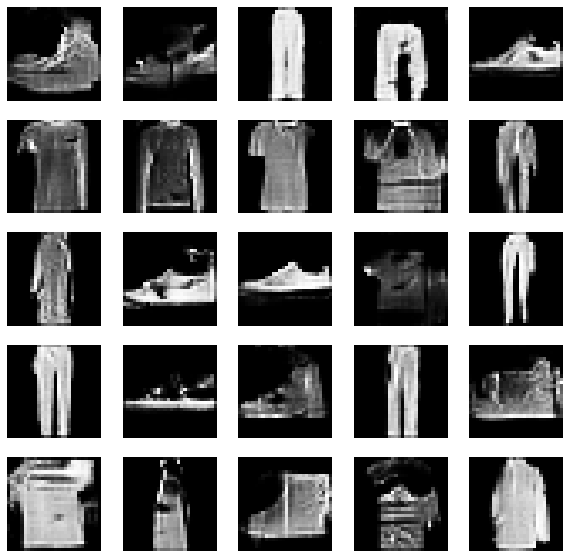

In [80]:
train_dcgan(gan, dataset, batch_size, num_features, epochs=20)

In [83]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:02d}.png'.format(epoch_no))

In [84]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)